#### Day 4

Convolutional Neural Networks Model for classification of Cats and Dogs Colored Images


#### Dogs vs Cats Image Classification Without Image Augmentation

How to classify images into pictures of cats or pictures of dogs. We'll build an image classifier using `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`.

## Specific concepts that will be covered:
In the process, we will build practical experience and develop intuition around the following concepts

* Building _data input pipelines_ using the `tf.keras.preprocessing.image.ImageDataGenerator` class — How can we efficiently work with data on disk to interface with our model?
* _Overfitting_ - what is it, how to identify it?

In [1]:
import tensorflow as tf

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os 
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

#### Data Loading

In [5]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=True)
print(zip_dir)


C:\Users\Rafael Louie\.keras\datasets\cats_and_dogs_filtered.zip


#### File Structure of cats and dogs dataset

The dataset we have downloaded has the following directory structure.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

We can list the directories with the following terminal command:

In [ ]:
zip_dir_base = os.path.dirname(zip_dir)

# List all files and directories
for dirpath, dirnames, filenames in os.walk(zip_dir_base):
    print(f'Found directory: {dirpath}')
    for file_name in filenames:
        print(file_name)



Assign the variables with the proper file path for the training and validation sets.

In [7]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats') #Directory that contains the training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') #Directory that contains the training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') #Directory that contains the validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs') #Directory that contains the validation dog pictures

#### Understanding our data

How many cats and dogs images in the training and validation directory

In [8]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_validation = num_cats_val + num_dogs_val

print("Number of training cat images: ", num_cats_tr)
print("Number of training dog images: ", num_dogs_tr)
print("Number of validation cat images: ", num_cats_val)
print("Number of validation dog images: ", num_dogs_val)

print("Total Number of images for training: ", total_train)
print("Total Number of validation images: ", total_validation)

Number of training cat images:  1000
Number of training dog images:  1000
Number of validation cat images:  500
Number of validation dog images:  500
Total Number of images for training:  2000
Total Number of validation images:  1000


#### Setting Model Parameters

In [9]:
BATCH_SIZE = 100
IMG_SHAPE = 150

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done using the class **tf.keras.preprocessing.image.ImageDataGenerator**.

We can set this up in a couple of lines of code.

In [10]:
train_image_generator = ImageDataGenerator(rescale=1./255) #Generator for the training data
validation_image_generator = ImageDataGenerator(rescale=1./255) #Generator for the validation data

After defining our generators for training and validation images, **flow_from_directory** method will load images from the disk, apply rescaling, and resize them using single line of code.

In [11]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [12]:
validate_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                                   directory=validation_dir,
                                                                   shuffle=False,
                                                                   target_size=(IMG_SHAPE, IMG_SHAPE),
                                                                   class_mode='binary')

Found 1000 images belonging to 2 classes.


#### Visualizing Training Images

We can visualize our training images by getting a batch of images from the training generator, and then plotting a few of them using `matplotlib`.

In [13]:
sample_training_images, _ = next(train_data_gen) 

The `next` function returns a batch from the dataset. One batch is a tuple of (*many images*, *many labels*). For right now, we're discarding the labels because we just want to look at the images.

In [16]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

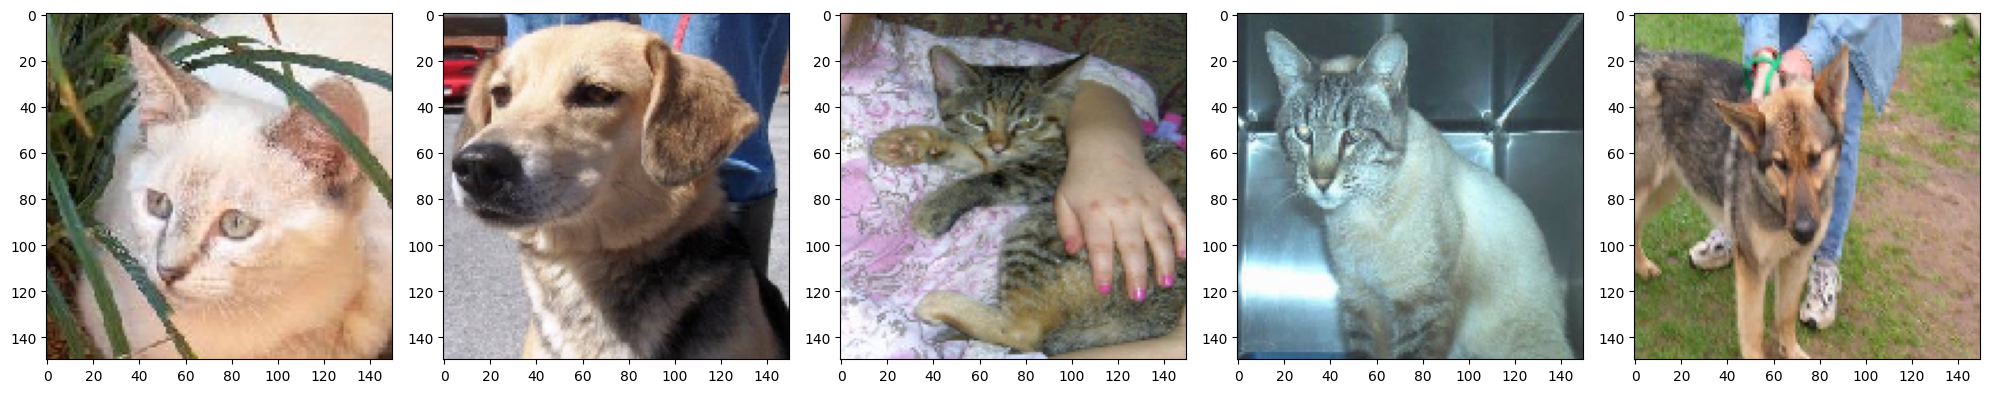

In [17]:
plotImages(sample_training_images[:5])

#### Model Creation

#### Define the model

The model consists of four convolution blocks with a max pool layer in each of them. Then we have a fully connected layer with 512 units, with a `relu` activation function. The model will output class probabilities for two classes — dogs and cats — using `softmax`. 

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

### Compile the model

As usual, we will use the `adam` optimizer. Since we output a softmax categorization, we'll use `sparse_categorical_crossentropy` as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [19]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

#### Model Summary

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

#### Train the model

It's time we train our network.

Since our batches are coming from a generator (`ImageDataGenerator`), we'll use `fit_generator` instead of `fit`.

In [ ]:
EPOCHS = 100

history = model.fit_generator(
    train_data_gen, steps_per_epoch=int(np.ceil(total_train/float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=validate_data_gen,
    validation_steps=int(np.ceil(total_validation/float(BATCH_SIZE)))
)

#### Visualizing results of the training

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()